checking for GPU availability to train larger models like ResNet -50

In [8]:
import tensorflow as tf

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_gpu_available())

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow is using GPU: True


2025-05-17 21:14:06.857671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-17 21:14:06.857780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# Configure TensorFlow to use GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Physical devices cannot be modified after being initialized


Installing necessary libraries

In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import PIL
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

In [13]:
# Enable mixed precision training (faster on GPU)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

Loading the dataset

In [19]:
train_dir = "/Users/ayushipradhan/Downloads/archive/train"
test_dir = "/Users/ayushipradhan/Downloads/archive/test"

batch_size = 64
num_classes = 7

# Image sizes
gray_img_size = (48, 48)
rgb_img_size = (224, 224)

Image generators for all models

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Data directories
train_dir = "/Users/ayushipradhan/Downloads/archive/train"
test_dir = "/Users/ayushipradhan/Downloads/archive/test"

# Data preprocessing function
def preprocess(image, label):
    image = image / 255.0  # Rescale pixel values
    return image, label

# Training set (80% of training data)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    validation_split=0.2,
    subset='training',
    seed=123
).map(preprocess)

# Validation set (20% of training data)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    validation_split=0.2,
    subset='validation',
    seed=123
).map(preprocess)

# Test set (completely separate)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=64
).map(preprocess)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply augmentation to training set only
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                       num_parallel_calls=tf.data.AUTOTUNE)

# Optimize dataset loading
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


Model architectures

Baseline CNN

In [34]:
from tensorflow.keras import layers, models

def build_basic_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [45]:
model = build_basic_cnn()
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.2382 - loss: 1.8244 - val_accuracy: 0.3109 - val_loss: 1.6994
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.2953 - loss: 1.7353 - val_accuracy: 0.3688 - val_loss: 1.6209
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3428 - loss: 1.6787 - val_accuracy: 0.3947 - val_loss: 1.5544
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3549 - loss: 1.6514 - val_accuracy: 0.4151 - val_loss: 1.5067
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3739 - loss: 1.6255 - val_accuracy: 0.4268 - val_loss: 1.4984
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3724 - loss: 1.6224 - val_accuracy: 0.4123 - val_loss: 1.5313
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3668 - loss: 1.6283 - val_accuracy: 0.4128 - val_loss: 1.5017
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3706 - loss: 1.6190 - val_acc

Deep CNN model

In [36]:
def build_deep_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(7, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


training the deep CNN model

In [37]:
deep_cnn = build_deep_cnn()
history_deep_cnn = deep_cnn.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
    ]
)

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.2156 - loss: 3.2179 - val_accuracy: 0.2252 - val_loss: 1.9435
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.2946 - loss: 2.0199 - val_accuracy: 0.3721 - val_loss: 1.6407
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.3509 - loss: 1.7110 - val_accuracy: 0.4153 - val_loss: 1.5422
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.3856 - loss: 1.6161 - val_accuracy: 0.4337 - val_loss: 1.4741
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.4013 - loss: 1.5759 - val_accuracy: 0.4646 - val_loss: 1.4196
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.4165 - loss: 1.5398 - val_accuracy: 0.4095 - val_loss: 1.5959
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.4275 - loss: 1.5255 - val_accuracy: 0.4874 - val_loss: 1.4230
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.4388 - loss: 1.5080 - 

VGG-16 (ignore the VGG-16 model. It was in my plan to do two custom models and two pretrained models bu due to memory issues I was unable to properly train this model)

In [26]:
# RGB Data Loaders (224x224)
train_rgb = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=(224, 224), color_mode='rgb', batch_size=64, 
    validation_split=0.2, subset='training', seed=123
).map(lambda x, y: (x/255., y))

val_rgb = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=(224, 224), color_mode='rgb', batch_size=64,
    validation_split=0.2, subset='validation', seed=123
).map(lambda x, y: (x/255., y))

test_rgb = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=(224, 224), color_mode='rgb', batch_size=64
).map(lambda x, y: (x/255., y))

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import mixed_precision

# Enable mixed precision for GPU
mixed_precision.set_global_policy('mixed_float16')

def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze weights

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(7, activation='softmax', dtype='float32')  # Note: float32 for stability
    ])
    
    model.compile(optimizer=optimizers.Adam(1e-4),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model


# Train
vgg_model = build_vgg16()
history_vgg = vgg_model.fit(
    train_rgb,
    epochs=30,
    validation_data=val_rgb,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

# Evaluate
test_loss, test_acc = vgg_model.evaluate(test_rgb)
print(f"VGG-16 Test Accuracy: {test_acc:.4f}")

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.
Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.1974 - loss: 2.0214 - val_accuracy: 0.2710 - val_loss: 1.7446
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.2334 - loss: 1.8744 - val_accuracy: 0.3174 - val_loss: 1.6980
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.2672 - loss: 1.8034 - val_accuracy: 0.3433 - val_loss: 1.6628
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.2866 - loss: 1.7569 - val_accuracy: 0.3607 - val_loss: 1.6340
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.3049 - loss: 1.7251 - val_accuracy: 0.3729 - val_loss: 1.6129
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.3242 - loss: 1.6911 - val_accuracy: 0.3719 - val_loss: 1.5959
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━

In [23]:
tf.keras.backend.clear_session()

ResNet-50 model

In [29]:
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(7, activation='softmax', dtype='float32')  
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Training the ResNet-50

In [30]:
resnet_model = build_resnet50()
history_resnet = resnet_model.fit(
    train_rgb,
    epochs=30,
    validation_data=val_rgb,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/30


2025-05-17 21:24:00.960740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


359/359 ━━━━━━━━━━━━━━━━━━━━ 244s 661ms/step - accuracy: 0.1776 - loss: 2.2545 - val_accuracy: 0.2456 - val_loss: 1.8084
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 283s 788ms/step - accuracy: 0.1917 - loss: 2.0305 - val_accuracy: 0.2456 - val_loss: 1.8058
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 292s 813ms/step - accuracy: 0.1892 - loss: 1.9937 - val_accuracy: 0.2460 - val_loss: 1.8030
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 292s 814ms/step - accuracy: 0.2023 - loss: 1.9555 - val_accuracy: 0.2463 - val_loss: 1.8019
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 297s 829ms/step - accuracy: 0.2031 - loss: 1.9278 - val_accuracy: 0.2468 - val_loss: 1.7993
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 308s 860ms/step - accuracy: 0.1959 - loss: 1.9167 - val_accuracy: 0.2454 - val_loss: 1.7985
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 303s 845ms/step - accuracy: 0.2015 - loss: 1.9038 - val_accuracy: 0.2475 - val_loss: 1.7967
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 314s 874ms/step - accuracy: 0.2165 - loss: 1.88

Evaluate the accuracy of ResNet50

In [31]:
test_loss, test_acc = resnet_model.evaluate(test_rgb)
print(f"ResNet-50 Test Accuracy: {test_acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 487ms/step - accuracy: 0.2693 - loss: 1.7606
ResNet-50 Test Accuracy: 0.2664


Comparing the results of the models

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


2025-05-18 02:46:01.912451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


2025-05-18 02:46:04.520506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 533ms/step


2025-05-18 02:48:04.490853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


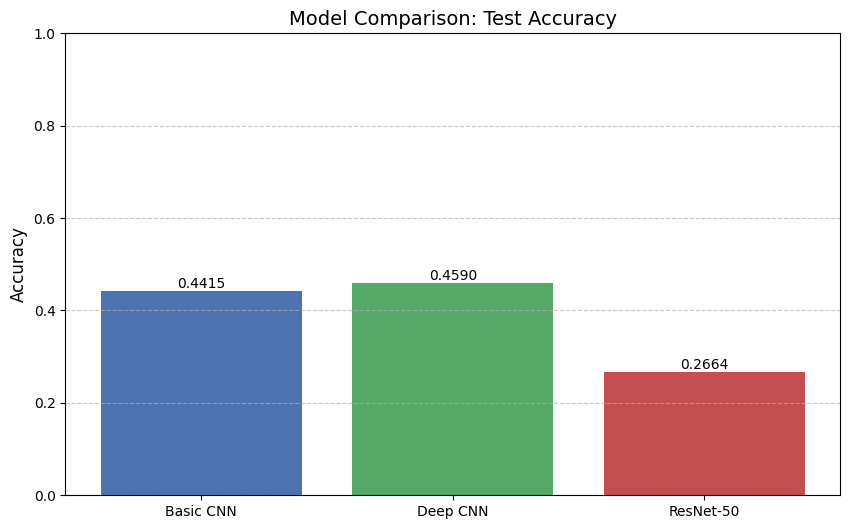

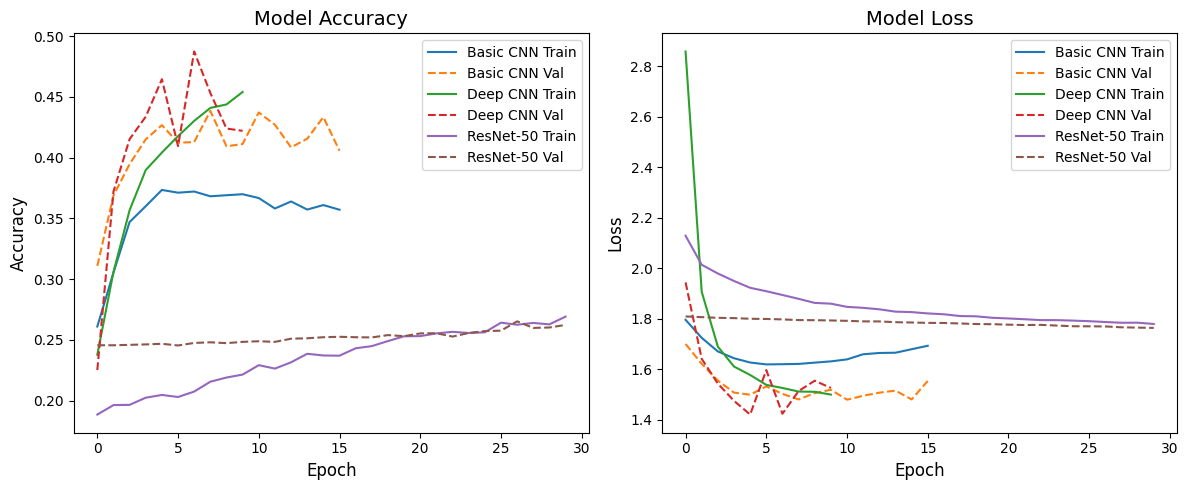

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Evaluate all models on test set
def evaluate_model(model, test_data):
    test_loss, test_acc = model.evaluate(test_data, verbose=0)
    y_pred = np.argmax(model.predict(test_data), axis=1)
    y_true = np.concatenate([y for x, y in test_data], axis=0)
    return test_acc, y_true, y_pred

# Get performance metrics
basic_cnn_acc, _, _ = evaluate_model(model, test_ds)
deep_cnn_acc, y_true_deep, y_pred_deep = evaluate_model(deep_cnn, test_ds)
resnet_acc, _, _ = evaluate_model(resnet_model, test_rgb)

# 2. Accuracy Comparison Bar Plot
plt.figure(figsize=(10, 6))
models = ['Basic CNN', 'Deep CNN', 'ResNet-50']
accuracies = [basic_cnn_acc, deep_cnn_acc, resnet_acc]
colors = ['#4C72B0', '#55A868', '#C44E52']

bars = plt.bar(models, accuracies, color=colors)
plt.title('Model Comparison: Test Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 5. Training Curves Comparison
def plot_history(histories, labels):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=label+' Train')
        plt.plot(history.history['val_accuracy'], '--', label=label+' Val')
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=label+' Train')
        plt.plot(history.history['val_loss'], '--', label=label+' Val')
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history([history, history_deep_cnn, history_resnet],
             ['Basic CNN', 'Deep CNN', 'ResNet-50'])